In [2]:
### import ###
import sys
sys.path.insert(1, '/home/thomas/research/projects/a549_40x/scripts/memes/')

import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import kneighbors_graph,BallTree
# from pymc import MCMC,flib,Model,MAP
# from ripser import Rips,ripser,plot_dgms
# from persim import PersImage
import scipy.io as sio
# import kmapper as km
# from kmapper import jupyter
from mpl_toolkits.mplot3d import Axes3D
from cell_class import single_cell,fluor_single_cell
import contour_class
import utility_tools
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
from scipy.signal import medfilt,wiener
from traj_class import single_cell_traj,fluor_single_cell_traj
# import bnpy
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,QuantileTransformer
from itertools import product
from sklearn.cluster import DBSCAN,KMeans,MeanShift,SpectralClustering,AgglomerativeClustering
from sklearn.metrics import silhouette_score#,davies_bouldin_score
import glob
# from neupy import algorithms, utils
from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter
from sklearn.manifold import MDS
from scipy import signal
from traj_scale import sp_traj_scaling,ssp_traj_scaling
from sklearn import datasets, svm
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.semi_supervised import LabelSpreading,LabelPropagation
import matplotlib.patches as mpatches
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from scipy.stats.mstats import mquantiles

In [2]:
### define parameters ###
main_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/result_bgcorr_norm/'

result_path=main_path+'result/'
    
sct_path=main_path+'single_cell_traj/'
sct_list=sorted(glob.glob(sct_path+'*long_traj'))
print(len(sct_list))

0


In [80]:
### key list ###
key_list=['Cell_AreaShape_Area', 'Cell_AreaShape_Center_X', 'Cell_AreaShape_Center_Y', 'Cell_AreaShape_Center_Z', \
          'Cell_AreaShape_Compactness', 'Cell_AreaShape_Eccentricity', 'Cell_AreaShape_EulerNumber', \
          'Cell_AreaShape_Extent', 'Cell_AreaShape_FormFactor', 'Cell_AreaShape_MajorAxisLength',\
          'Cell_AreaShape_MaxFeretDiameter', 'Cell_AreaShape_MaximumRadius', 'Cell_AreaShape_MeanRadius', \
          'Cell_AreaShape_MedianRadius', 'Cell_AreaShape_MinFeretDiameter', 'Cell_AreaShape_MinorAxisLength', \
          'Cell_AreaShape_Orientation', 'Cell_AreaShape_Perimeter', 'Cell_AreaShape_Solidity']
key_mask=np.ones((len(key_list),),dtype=bool)
key_mask[key_list.index('Cell_AreaShape_Center_Y')]=False
key_mask[key_list.index('Cell_AreaShape_Center_X')]=False
key_mask[key_list.index('Cell_AreaShape_Center_Z')]=False
key_mask[key_list.index('Cell_AreaShape_EulerNumber')]=False
key_mask[key_list.index('Cell_AreaShape_Orientation')]=False
print(key_list.index('Cell_AreaShape_Center_X'),key_list.index('Cell_AreaShape_Center_Y'),key_list.index('Cell_AreaShape_Center_Z'),key_list.index('Cell_AreaShape_EulerNumber'))
print(key_list.index('Cell_AreaShape_MeanRadius'))

(1, 2, 3, 6)
12


calculate scale_morph_pca, vimentin_haralick_scaler, vimentin_haralick_scale_pca

In [ ]:
### with no emt ###
wd_size=12
scale_features=[]
scale_contours=[]
all_vim0=[]
all_t0=[]
all_haralick0=[]

all_ori_morph_cord=[]
all_ori_vim_cord=[]

count=0

for i in range(len(sct_list)):
    print(sct_list[i])
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp)
    
    mask=sct.traj_vimentin_feature_values[0]!=0 
    traj_t=sct.traj_seri[mask][:,0]
    traj_morph=sct.traj_cord[mask]
    traj_vim=sct.traj_vimentin_haralick_pca_cord[mask]
    traj_vim_haralick=sct.traj_vimentin_feature_values[3][mask]

    traj_scale_contour,traj_scale_contour_with_vim,traj_scale_haralick,scale_t=sp_traj_scaling(sct,t_cutoff=6,t_range=48)
    # traj_scale_contour,traj_scale_contour_with_vim,traj_scale_haralick,morph_scale_t,vim_scale_t=ssp_traj_scaling(sct)

    if len(traj_scale_contour)>0:
        scale_contours.append(traj_scale_contour_with_vim)
    #     all_vim0.append(traj_vim)
        all_haralick0.append(traj_scale_haralick)
        all_t0.append(traj_t)

        all_ori_morph_cord.append(traj_morph)
        all_ori_vim_cord.append(traj_vim)
        count+=1
print(count)

In [ ]:
### with emt ###
wd_size=12
scale_features=[]
scale_contours=[]
all_vim0=[]
all_t0=[]
all_haralick0=[]

all_ori_morph_cord=[]
all_ori_vim_cord=[]

count=0

for i in range(len(sct_list)):
    print(sct_list[i])
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp)
    
    mask=sct.traj_vimentin_feature_values[0]!=0 
    traj_t=sct.traj_seri[mask][:,0]
    traj_morph=sct.traj_cord[mask]
    traj_vim=sct.traj_vimentin_haralick_pca_cord[mask]
    traj_vim_haralick=sct.traj_vimentin_feature_values[3][mask]
    
#     if np.mean(traj_morph[:24,0])<100 and np.mean(traj_vim[:24,0])<2:
    if np.mean(traj_morph[:36,0])<np.mean(traj_morph[-36:,0]) or np.mean(traj_vim[:36,0])<np.mean(traj_vim[-36:,0]):
    
    #     dot_color=np.arange(traj_t.shape[0])
    #     cm=plt.cm.get_cmap('jet')
    #     sc=plt.scatter(traj_vim[:,0],traj_vim[:,1],c=dot_color,cmap=cm)
    #     plt.colorbar(sc)
    #     plt.show()

    # #     plt.scatter(np.arange(morph_smad.shape[0]),np.sum(morph_smad,axis=1),s=2,color='b')#,c=dot_color[:-12],cmap=cm)
    #     plt.scatter(np.arange(morph_sstd.shape[0]),np.sum(morph_sstd,axis=1),s=2,c=dot_color[:-wd_size],cmap=cm)
    #     plt.show()


    #     traj_scale_contour,traj_scale_haralick=traj_scaling(sct,wd_size=12,t_range=72,sort_range=6)
        traj_scale_contour,traj_scale_contour_with_vim,traj_scale_haralick,scale_t=sp_traj_scaling(sct,t_cutoff=6,t_range=48)
        # traj_scale_contour,traj_scale_contour_with_vim,traj_scale_haralick,morph_scale_t,vim_scale_t=ssp_traj_scaling(sct)

    #     dot_color=np.arange(traj_t.shape[0])
    #     cm=plt.cm.get_cmap('jet')
    #     sc=plt.scatter(traj_t,sct.traj_vimentin_feature_values[0][mask],c=dot_color,cmap=cm)
    #     plt.colorbar(sc)
    #     plt.show()
        if len(traj_scale_contour)>0:
            scale_contours.append(traj_scale_contour_with_vim)
        #     all_vim0.append(traj_vim)
            all_haralick0.append(traj_scale_haralick)
            all_t0.append(traj_t)

            all_ori_morph_cord.append(traj_morph)
            all_ori_vim_cord.append(traj_vim)
            count+=1
print(count)

In [91]:
### plotting something ###
# all_t=np.concatenate(all_t0,axis=0)
# mask1=all_t<24
# ori_morph=np.vstack(all_ori_morph_cord)
# ori_vim=np.vstack(all_ori_vim_cord)

# E_data=np.column_stack((ori_morph[mask1],ori_vim[mask1]))

# mask2=(all_t>60)&(all_t<84)
# P_data=np.column_stack((ori_morph[mask2],ori_vim[mask2]))

# mask3=all_t>552
# M_data=np.column_stack((ori_morph[mask3],ori_vim[mask3]))
# plt.scatter(P_data[:,0],P_data[:,8],s=1,color='r')

# plt.scatter(E_data[:,0],E_data[:,8],s=0.1,color='b')
# # plt.scatter(M_data[:,0],M_data[:,8],s=1,color='r')
# plt.show()

In [92]:
X1=np.vstack(scale_contours)
print(X1.shape)
pca1 = decomposition.PCA(n_components =0.98,svd_solver= 'full')
Y1 = pca1.fit_transform(X1)
print(pca1.explained_variance_ratio_)

X2=np.vstack(all_haralick0)
# print(np.concatenate(all_t0).shape)
# # t_mask=np.concatenate(all_t0)<144   
# # # X2=np.vstack(scale_vim)
scaler2 = StandardScaler()
X2=scaler2.fit_transform(X2)
# print(X2.shape)

pca2 = decomposition.PCA(n_components =0.98,svd_solver= 'full')
Y2 = pca2.fit_transform(X2)
print(pca2.explained_variance_ratio_)

with open (main_path+'scale_morph_pca', 'wb') as fp:
    pickle.dump(pca1,fp)
with open (main_path+'vimentin_haralick_scaler', 'wb') as fp:
    pickle.dump(scaler2,fp)
with open (main_path+'vimentin_haralick_scale_pca', 'wb') as fp:
    pickle.dump(pca2,fp)

morph_pc_scaler=StandardScaler().fit(Y1.flatten()[:,None])
with open (main_path+'morph_pc_scaler', 'wb') as fp:
    pickle.dump(morph_pc_scaler,fp)
vim_pc_scaler=StandardScaler().fit(Y2.flatten()[:,None])
with open (main_path+'vim_pc_scaler', 'wb') as fp:
    pickle.dump(vim_pc_scaler,fp)

(51034, 300)
[0.8350034  0.09834498 0.01415986 0.01252001 0.0090582  0.00775496
 0.0044939 ]
[0.58234735 0.21485381 0.08587007 0.05405747 0.02729872 0.01251357
 0.01125967]


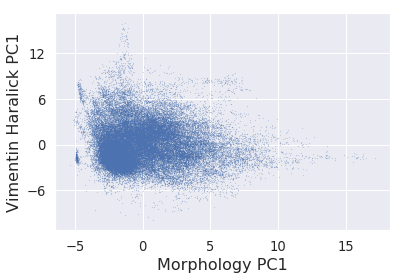

(array([2.68174382, 0.92034204, 0.34922285, 0.32837913, 0.27931488,
       0.25844186, 0.19673655]), array([2.75145699, 1.67125688, 1.05655613, 0.83830011, 0.59572083,
       0.40333168, 0.38259077]))


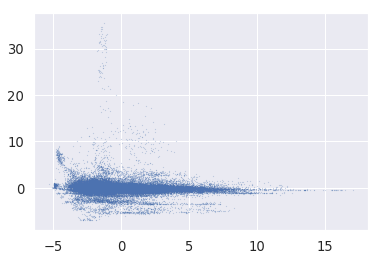

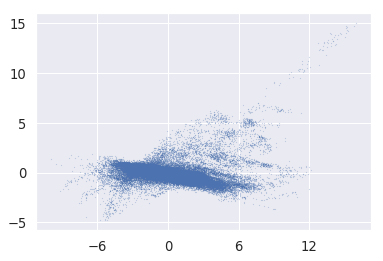

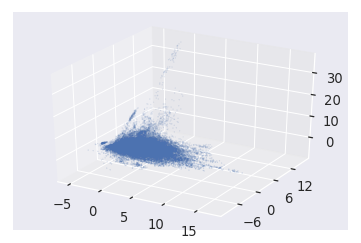

In [93]:

plt.scatter(Y1[:,0],Y2[:,0],s=0.01)
# plt.axis([-4,4,-4,4])
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.savefig(result_path+'all_scatter.png',dpi=300)
plt.show()

# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# sns.kdeplot(Y1[:,0],Y2[:,0],n_levels=50,shade=True,cmap=cmap)
# # plt.axis([-4,4,-100,200])
# # plt.savefig(result_path+'all_kde.png',dpi=300)

# plt.show()

print(np.std(Y1,axis=0),np.std(Y2,axis=0))
plt.scatter(Y1[:,0],Y2[:,1],s=0.01)
plt.show()
plt.scatter(Y2[:,0],Y2[:,2],s=0.01)
plt.show()


# plt.scatter(Y[:,0],Y[:,1],s=0.01)
# plt.show()
# # sns.kdeplot(Y[:,0],Y[:,1],n_levels=50,shade=True)
# # # # plt.axis([-2.5,2.5,-2.5,2.5])
# # plt.show()

ax = plt.axes(projection='3d')
ax.scatter3D(Y1[:,0],Y2[:,0],Y2[:,1],s=0.01)
# #     ax.view_init(50, 25)
plt.show()

(array([7.19189082, 0.84704607, 0.12195899, 0.10783496, 0.07801833,
       0.0667935 , 0.03870603]), array([0.8350034 , 0.09834498, 0.01415986, 0.01252001, 0.0090582 ,
       0.00775496, 0.0044939 ]))


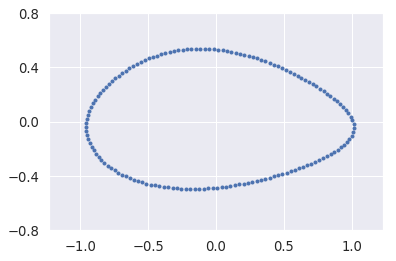

points = shape_array0
points = shape_array1
points = shape_array3


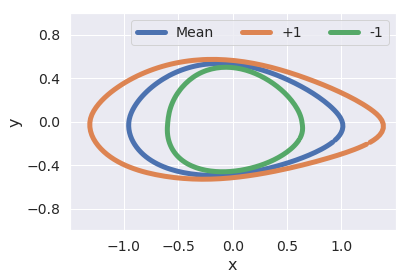

points = shape_array0
points = shape_array1
points = shape_array3


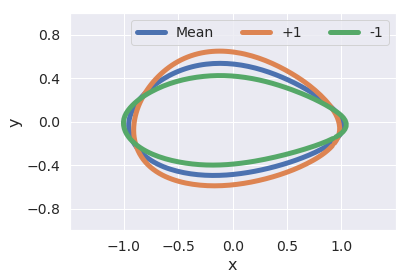

In [94]:
variances=pca1.explained_variance_
variance_ratio=pca1.explained_variance_ratio_ 
tot_variance=np.sum(variances)
stds=np.sqrt(variances)
print(variances,pca1.explained_variance_ratio_)

plt.plot(pca1.mean_[0::2],pca1.mean_[1::2],'.')
plt.axis('equal')
plt.axis([-1.5,1.5,-0.8,0.8])
# plt.savefig(result_path+'mean_contour.png',dpi=300)

plt.show()

#-------plot principal modes-------------------------
for pci in range(2):#variances.shape[0]):
    cell_posi=np.zeros((variances.shape[0],))
    mode_std1=copy.copy(cell_posi)
    mode_std1[pci]=1
    mode_std2=copy.copy(cell_posi)
    mode_std2[pci]=2
    mode_std_1=copy.copy(cell_posi)
    mode_std_1[pci]=-1
    mode_std_2=copy.copy(cell_posi)
    mode_std_2[pci]=-2

    shape_array0=pca1.inverse_transform(cell_posi*stds)
    shape_array1=pca1.inverse_transform(mode_std1*stds)
    shape_array2=pca1.inverse_transform(mode_std2*stds)
    shape_array3=pca1.inverse_transform(mode_std_1*stds)
    shape_array4=pca1.inverse_transform(mode_std_2*stds)

    for i in [0,1,3]:
        com_str='points = shape_array'+str(i)
        print(com_str)
        exec(com_str)
    #     print(points.shape)
        #fig, ax = plt.subplots(figsize=(12, 12))

        plt.plot(points[0::2], points[1::2], '-',linewidth=5)
        plt.legend(('Mean','+1','-1'),fontsize=14,ncol=3)
    plt.xlabel('x',fontsize=16)
    plt.ylabel('y',fontsize=16)

    plt.xticks(np.arange(-1,1.1,0.5),fontsize=14)
    plt.yticks(np.arange(-0.8,0.9,0.4),fontsize=14)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1,1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#     plt.savefig(result_path+'mode'+str(pci+1)+'.png',dpi=300)   
    plt.show()



In [95]:
# from pomegranate import *
# EM_data=np.vstack((E_data,M_data))
# gmm = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, 2, EM_data)
# gmm_proba=gmm.predict_proba(EM_data)
# gmm_labels=gmm.predict(EM_data)

# plt.scatter(EM_data[:,0],EM_data[:,1],c=gmm_labels,s=1)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.axis('equal')
# plt.show()

In [96]:
def plot_gmm(data,gmm):

#     plt.hist(data,bins=30,weights=np.ones_like(data)/float(len(data)))

    x = np.linspace(mquantiles(data,[0.01])[0], mquantiles(data,[0.99])[0], 1000).reshape(1000,1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    plt.figure(figsize=(8,6))
    plt.plot(x, pdf, '-b')
#     plt.xlabel('Morphology PC1',fontsize=16)

    plt.xlabel('Vimentin Haralick PC4',fontsize=16)
    plt.ylabel('Log likelihood',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
#     plt.savefig(result_path+'vim_pc4_gmm.png',dpi=300)
    plt.show()
    
#     plt.hist(gmm.predict_proba(x))
#     plt.show()
    
    sns.kdeplot(data[(data>mquantiles(data,[0.02])[0])&(data<mquantiles(data,[0.98])[0])],color='blue')
#     plt.xlabel('Vimentin Haralick PC4',fontsize=16)
#     plt.ylabel('Log likelihood',fontsize=16)
    plt.show()

[0.89649763 0.831763   0.31000283 0.28112253]
[2.2231037  1.91933342 0.7333404  0.53293631]
[2.94820659 2.43965491 1.22674182 0.75213918]
1.1548426897


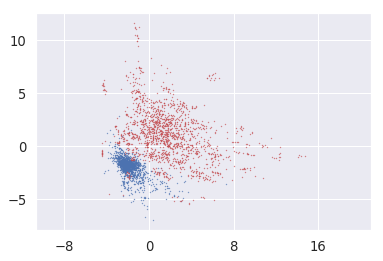

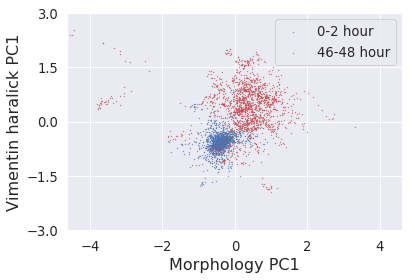

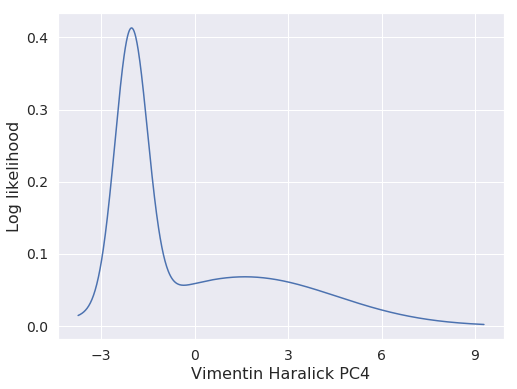

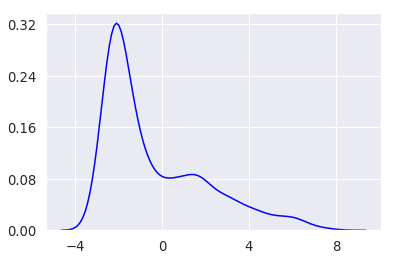

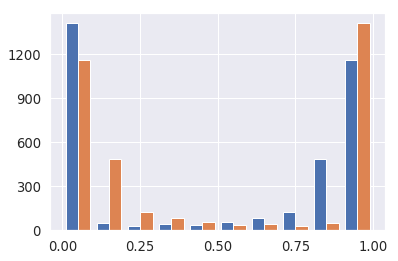

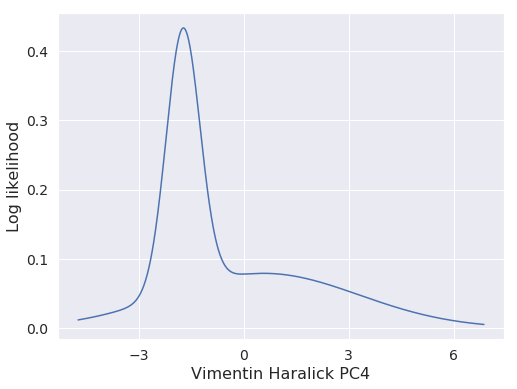

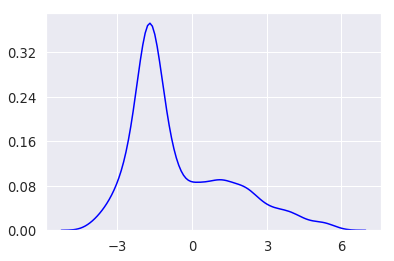

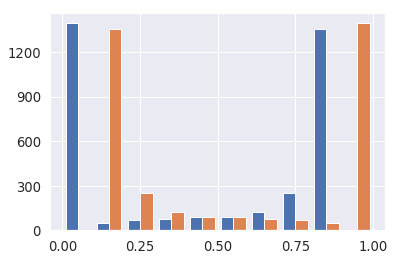

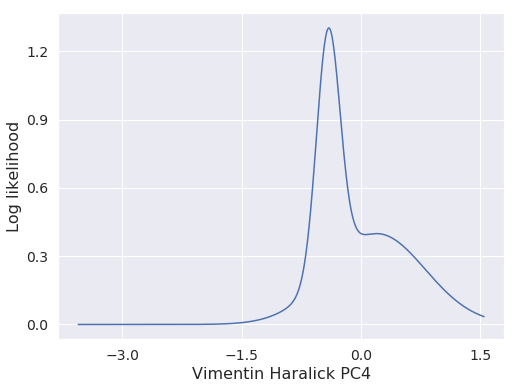

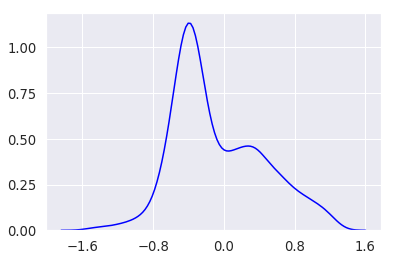

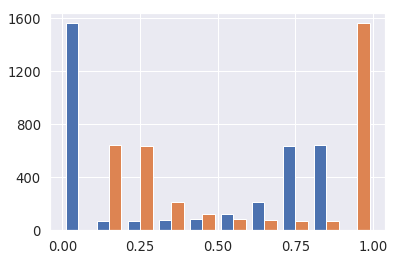

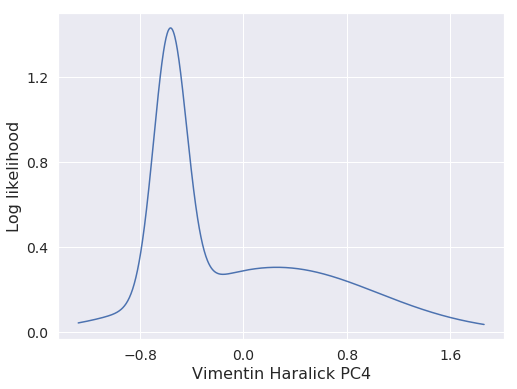

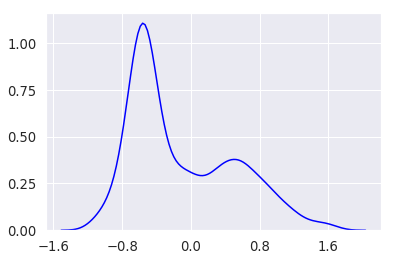

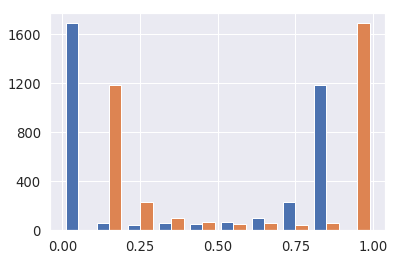

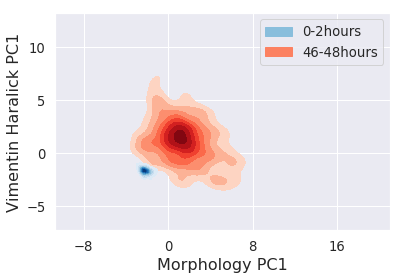

In [101]:
all_t=np.concatenate(all_t0,axis=0)

sY1=Y1.copy()
sY2=Y2.copy()
for i1 in range(Y1.shape[1]):
    sY1[:,i1]=morph_pc_scaler.transform(Y1[:,i1][:,None])[:,0]
for i2 in range(Y2.shape[1]):
    sY2[:,i2]=vim_pc_scaler.transform(Y2[:,i2][:,None])[:,0]

sY2[:,2]=-sY2[:,2]

mask1=all_t<24
E_data=np.column_stack((sY1[mask1][:,0],sY2[mask1][:,[0,2,3]]))
print(np.std(E_data,axis=0))

mask2=(all_t>276)&(all_t<301)
P_data=np.column_stack((sY1[mask2][:,0],sY2[mask2][:,[0,2,3]]))
print(np.std(P_data,axis=0))
mask3=all_t>552
# mask4=Y1[:,0]>-3
M_data=np.column_stack((sY1[mask3][:,0],sY2[mask3][:,[0,2,3]]))
print(np.std(M_data,axis=0))
print(E_data.shape[0]*1.0/M_data.shape[0])


E_data_7d=np.column_stack((sY1[mask1][:,:3],sY2[mask1][:,:4]))
M_data_7d=np.column_stack((sY1[mask3][:,:3],sY2[mask3][:,:4]))
EM_data_7d=np.vstack((E_data_7d,M_data_7d))


# mask=clustering.labels_==0
# M_data=M_data[mask]

EM_data=np.vstack((E_data,M_data))
yl=np.concatenate((np.zeros((E_data.shape[0],)),np.ones((M_data.shape[0]))))
tl=['0-2hour','46-48hour']
t_label=[tl[int(i)] for i in yl]
EPM_data=np.vstack((EM_data,P_data))

# clustering = AgglomerativeClustering(linkage='ward', n_clusters=2).fit(M_data)
# clustering=SpectralClustering(n_clusters=2).fit(M_data)
#clustering=MeanShift(bandwidth=1,cluster_all=False).fit(EM_data)
#clustering = DBSCAN(eps=1, min_samples=50).fit(EM_data)
# print(np.unique(clustering.labels_))
# plt.scatter(M_data[:,0],M_data[:,1],c=clustering.labels_,s=1)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.show()


plt.scatter(E_data[:,0],E_data[:,1],s=0.1,color='b')
plt.scatter(M_data[:,0],M_data[:,1],s=0.1,color='r')
# plt.scatter(P_data[:,0],P_data[:,1],s=0.1,color='g')
plt.axis('equal')
plt.show()




# E_data=PC1_scaler.transform(E_data)
# M_data=PC1_scaler.transform(M_data)
# EM_data=PC1_scaler.transform(EM_data)


plt.scatter(E_data[:,2],E_data[:,3],s=0.1,color='b')
plt.scatter(M_data[:,2],M_data[:,3],s=0.1,color='r')
# plt.scatter(P_data[:,0],P_data[:,1],s=0.1,color='g')
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin haralick PC1',fontsize=16)
plt.legend(['0-2 hour','46-48 hour'])
plt.axis('equal')
plt.axis([-3,3,-3,3])
plt.show()


gmm0=mixture.GaussianMixture(n_components=2,covariance_type='full').fit(EM_data[:,0][:,None])
ori_gmm0_proba=gmm0.predict_proba(EM_data[:,0][:,None])
ori_label0=gmm0.predict(EM_data[:,0][:,None])

ord_label0=np.sort(np.unique(ori_label0))[np.argsort(gmm0.means_[:,0])]
gmm0_label=ori_label0.copy()
gmm0_proba=ori_gmm0_proba.copy()
for l in range(len(ord_label0)):
    gmm0_label[np.where(ori_label0==ord_label0[l])]=l
    gmm0_proba[:,l]=ori_gmm0_proba[:,ord_label0[l]]
plot_gmm(EM_data[:,0],gmm0)
plt.hist(gmm0_proba)
plt.show()

gmm1=mixture.GaussianMixture(n_components=2,covariance_type='full').fit(EM_data[:,1][:,None])

ori_gmm1_proba=gmm1.predict_proba(EM_data[:,1][:,None])

ori_label1=gmm1.predict(EM_data[:,1][:,None])
ord_label1=np.sort(np.unique(ori_label1))[np.argsort(gmm1.means_[:,0])]
gmm1_label=ori_label1.copy()
gmm1_proba=ori_gmm1_proba.copy()
for l in range(len(ord_label1)):
    gmm1_label[np.where(ori_label1==ord_label1[l])]=l
    gmm1_proba[:,l]=ori_gmm1_proba[:,ord_label1[l]]
plot_gmm(EM_data[:,1],gmm1)
plt.hist(gmm1_proba)
plt.show()


# gmm2=mixture.BayesianGaussianMixture(n_components=2,covariance_type='full', weight_concentration_prior_type='dirichlet_process').fit(EM_data[:,2][EM_data[:,2]<3][:,None])
gmm2=mixture.GaussianMixture(n_components=2,covariance_type='full').fit(EM_data[:,2][EM_data[:,2]>-1.5][:,None])

# gmm2=mixture.GaussianMixture(n_components=2,covariance_type='full').fit(EM_data[:,2][:,None])

ori_gmm2_proba=gmm2.predict_proba(EM_data[:,2][:,None])
ori_label2=gmm2.predict(EM_data[:,2][:,None])
ord_label2=np.sort(np.unique(ori_label2))[np.argsort(gmm2.means_[:,0])]
gmm2_label=ori_label2.copy()
gmm2_proba=ori_gmm2_proba.copy()
for l in range(len(ord_label2)):
    gmm2_label[np.where(ori_label2==ord_label2[l])]=l
    gmm2_proba[:,l]=ori_gmm2_proba[:,ord_label2[l]]

plot_gmm(EM_data[:,2],gmm2)
plt.hist(gmm2_proba)
plt.show()
# gmm3=mixture.GaussianMixture(n_components=2,covariance_type='full').fit(EM_data[:,3][EM_data[:,3]>-1.5][:,None])

# gmm3=mixture.GaussianMixture(n_components=2,covariance_type='full').fit(EM_data[:,3][:,None])
ori_gmm3_proba=gmm3.predict_proba(EM_data[:,3][:,None])

ori_label3=gmm3.predict(EM_data[:,3][:,None])
ord_label3=np.sort(np.unique(ori_label3))[np.argsort(gmm3.means_[:,0])]
gmm3_label=ori_label3.copy()
gmm3_proba=ori_gmm3_proba.copy()

for l in range(len(ord_label3)):
    gmm3_label[np.where(ori_label3==ord_label3[l])]=l
    gmm3_proba[:,l]=ori_gmm3_proba[:,ord_label3[l]]

plot_gmm(EM_data[:,3],gmm3)
plt.hist(gmm3_proba)
plt.show()



# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# sns.kdeplot(EM_data[:,0],EM_data[:,1],n_levels=30,shade=True,cmap=cmap)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis('equal')
# # plt.savefig(result_path+'EM_kde.png',dpi=300)
# plt.show()

label_patch2=mpatches.Patch(color=sns.color_palette('Reds')[2],label='46-48hours')
label_patch1=mpatches.Patch(color=sns.color_palette('Blues')[2],label='0-2hours')
label_patches=[label_patch1,label_patch2]
ax = sns.kdeplot(M_data[:,0],M_data[:,1],cmap="Reds",n_levels=10, shade=True, shade_lowest=False)
ax = sns.kdeplot(E_data[:,0],E_data[:,1],cmap="Blues", n_levels=10, shade=True, shade_lowest=False)
plt.legend(handles=label_patches, loc='upper right')
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
plt.axis('equal')
# plt.savefig(result_path+'EM_kde_seperate.png',dpi=300)
plt.show()

# ax = plt.axes(projection='3d')
# ax.scatter3D(scaler.transform(E_data)[:,0],scaler.transform(E_data)[:,1],scaler.transform(E_data)[:,2],s=0.01,color='r')
# ax.scatter3D(scaler.transform(M_data)[:,0],scaler.transform(M_data)[:,1],scaler.transform(M_data)[:,2],s=0.01,color='b')
# plt.show()

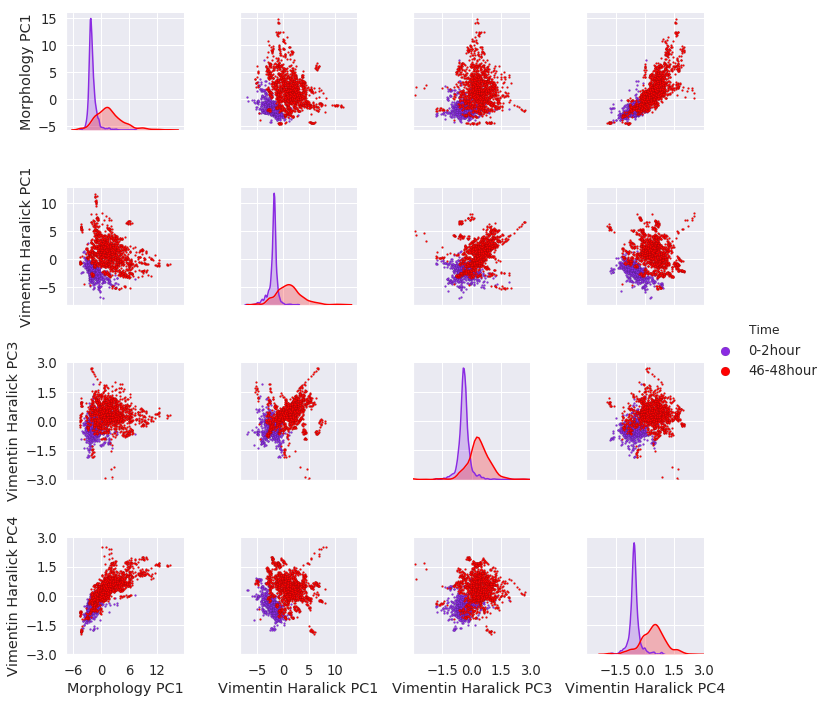

In [102]:
X=EM_data
value_name=['Morphology PC1','Vimentin Haralick PC1','Vimentin Haralick PC3','Vimentin Haralick PC4']
data = pd.DataFrame(X, columns=value_name)
data['Time']=t_label

color_list = ["blueviolet", "red"]
c_map=sns.color_palette(color_list)


sns.set(font_scale=1.2)
g=sns.pairplot(data, hue="Time",diag_kind='kde',vars=value_name,\
             plot_kws=dict(edgecolor='k', linewidth=0.1,s=4),palette=c_map) #markers=["o", "s"])

g.axes[0,2].set_xlim((-3,3))
g.axes[0,3].set_xlim((-3,3))
g.axes[2,0].set_ylim((-3,3))
g.axes[3,0].set_ylim((-3,3))

for lh in g._legend.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [80]

plt.savefig(result_path+'pair_plot.png',dpi=300)
plt.show()

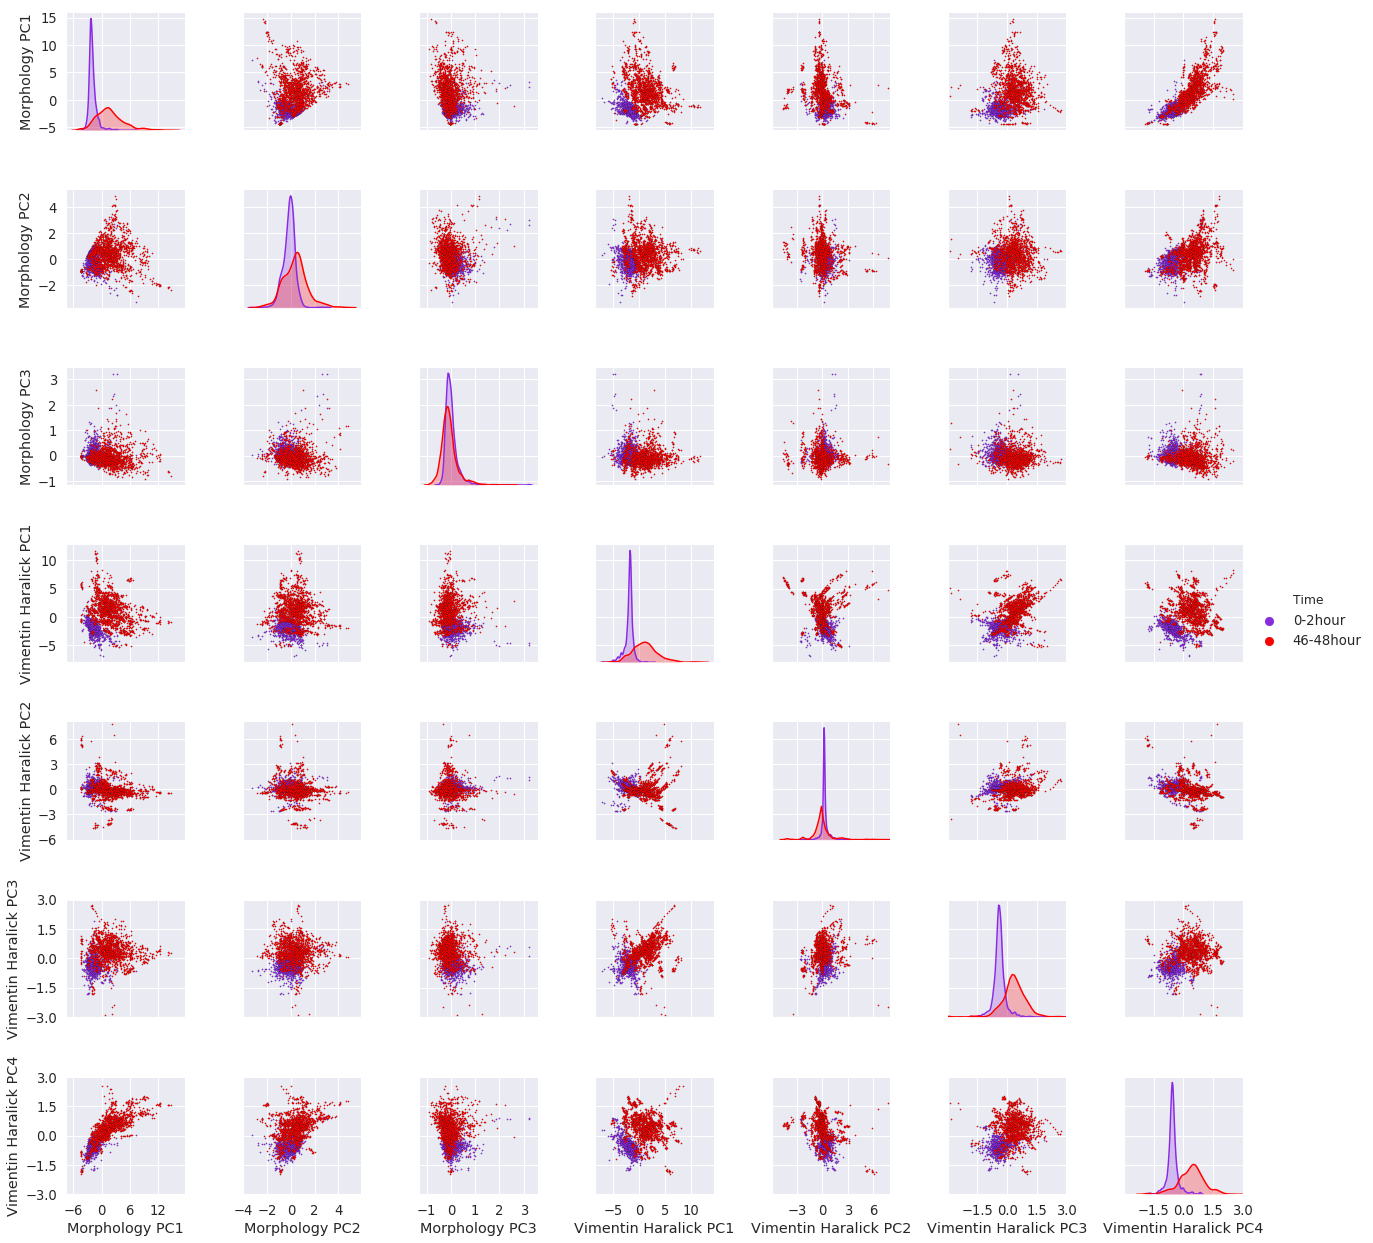

In [103]:
# mask1=all_t<24
# E_data=np.column_stack((sY1[mask1][:,:],sY2[mask1][:,:]))
# print(np.std(E_data,axis=0))

# mask2=(all_t>276)&(all_t<301)
# P_data=np.column_stack((sY1[mask2][:,:],sY2[mask2][:,:]))
# print(np.std(P_data,axis=0))
# mask3=all_t>552
# # mask4=Y1[:,0]>-3
# M_data=np.column_stack((sY1[mask3][:,:],sY2[mask3][:,:]))
# print(np.std(M_data,axis=0))
# print(E_data.shape)
# X=np.vstack((E_data,M_data))
X=EM_data_7d
# value_name=['MPC1','MPC2','MPC3','MPC4','MPC5','MPC6','MPC7','VHPC1','VHPC2','VHPC3','VHPC4','VHPC5','VHPC6','VHPC7']

value_name=['Morphology PC1','Morphology PC2','Morphology PC3','Vimentin Haralick PC1','Vimentin Haralick PC2','Vimentin Haralick PC3','Vimentin Haralick PC4']
# value_name=['Morphology PC1','Vimentin Haralick PC1','Vimentin Haralick PC3','Vimentin Haralick PC4']
data = pd.DataFrame(X, columns=value_name)
data['Time']=t_label

sns.set(font_scale=1.2)
g=sns.pairplot(data, hue="Time",diag_kind='kde',vars=value_name,\
             plot_kws=dict(edgecolor='k', linewidth=0.1,s=2),palette=c_map)
g.axes[0,4].set_xlim((-6,8))
g.axes[4,0].set_ylim((-6,8))

g.axes[0,5].set_xlim((-3,3))
g.axes[0,6].set_xlim((-3,3))
g.axes[5,0].set_ylim((-3,3))
g.axes[6,0].set_ylim((-3,3))

for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [80]

plt.savefig(result_path+'pair_plot_7D.png',dpi=300)

plt.show()

# g = sns.pairplot(data,hue='time')
# pp = sns.pairplot(wines[cols], size=1.8, aspect=1.8,
#                   plot_kws=dict(edgecolor="k", linewidth=0.5),
#                   diag_kind="kde", diag_kws=dict(shade=True))

# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

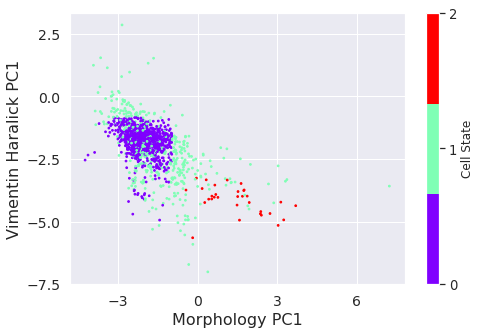

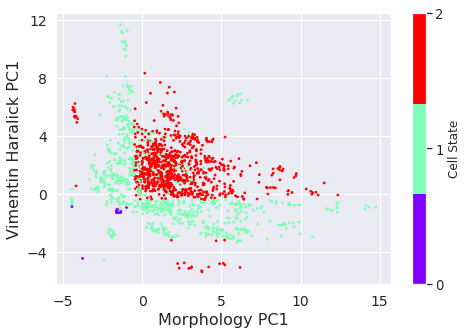

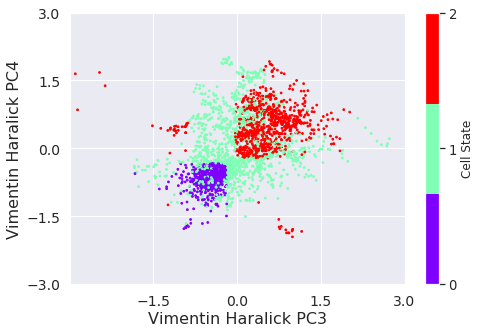

(3493, 4)


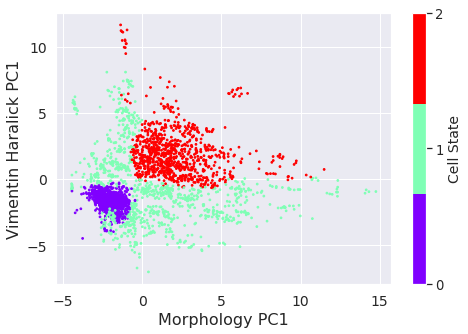

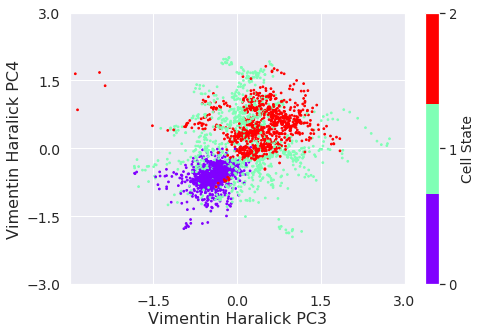

In [106]:
# gmm=mixture.BayesianGaussianMixture(n_components=7,covariance_type='full', weight_concentration_prior_type='dirichlet_process').fit(EM_data)

X=EM_data
yl=np.concatenate((np.zeros((E_data.shape[0],)),np.ones((M_data.shape[0]))))

mask_i=((gmm0_label==0)|(X[:,0]<np.sort(gmm0.means_[:,0])[0]))&\
      ((gmm1_label==0)|(X[:,1]<np.sort(gmm1.means_[:,0])[0]))&\
      ((gmm2_label==0)|(X[:,2]<np.sort(gmm2.means_[:,0])[0]))&\
    ((gmm3_label==0)|(X[:,3]<np.sort(gmm3.means_[:,0])[0]))

#mask_f=(gmm0_proba[:,1]>0.9)&(gmm1_proba[:,1]>0.9)&(gmm2_proba[:,1]>0.9)&(gmm3_proba[:,1]>0.9)
mask_f=((gmm0_proba[:,1]>0.9)|(X[:,0]>np.sort(gmm0.means_[:,0])[1]))&\
    ((gmm1_proba[:,1]>0.9)|(X[:,1]>np.sort(gmm1.means_[:,0])[1]))&\
    ((gmm2_proba[:,1]>0.9)|(X[:,2]>np.sort(gmm2.means_[:,0])[1]))&\
    ((gmm3_proba[:,1]>0.9)|(X[:,3]>np.sort(gmm3.means_[:,0])[1]))


yl[mask_i]=0
yl[mask_f]=2
yl[~(mask_i|mask_f)]=1


cmap = plt.cm.rainbow  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 2, 4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


plt.figure(figsize=(7.5,5))

plt.scatter(E_data[:, 0], E_data[:, 1], c=yl[:E_data.shape[0]], cmap=cmap,norm=norm, s=3)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=12)
plt.axis('tight')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'E_gmm_label_pc1.png',dpi=300)
plt.show()


plt.figure(figsize=(7.5,5))

plt.scatter(M_data[:, 0], M_data[:, 1], c=yl[E_data.shape[0]:], cmap=cmap,norm=norm, s=3)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=12)
plt.axis('tight')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'M_gmm_label_pc1.png',dpi=300)
plt.show()


plt.figure(figsize=(7.5,5))

plt.scatter(EM_data[:, 2], EM_data[:, 3], c=yl,  cmap=cmap,norm=norm, s=3)
plt.xlabel('Vimentin Haralick PC3',fontsize=16)
plt.ylabel('Vimentin Haralick PC4',fontsize=16)

cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=12)
plt.axis('tight')
plt.axis([-3,3,-3,3])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'gmm_label_pc34.png',dpi=300)

plt.show()


ls2=LabelSpreading(kernel='knn',n_neighbors=50,alpha=0.5)
print(X.shape)
ls2.fit(X,yl)


ls2_labels=ls2.predict(X)
ls2_proba=ls2.predict_proba(X)
plt.figure(figsize=(7.5,5))

plt.scatter(X[:, 0], X[:, 1], c=ls2_labels, zorder=10, cmap=cmap,norm=norm,s=3)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=14)
plt.axis('tight')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'label_pc1.png',dpi=300)

plt.show()

plt.figure(figsize=(7.5,5))

plt.scatter(X[:, 2], X[:, 3], c=ls2_labels, zorder=10, cmap=cmap,norm=norm,s=3)
plt.xlabel('Vimentin Haralick PC3',fontsize=16)
plt.ylabel('Vimentin Haralick PC4',fontsize=16)

cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=14)
plt.axis('equal')
plt.axis('tight')
plt.axis([-3,3,-3,3])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'label_pc34.png',dpi=300)

plt.show()

# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
# f, ax = plt.subplots()
# points = ax.scatter(X[:,0], X[:,1], c=ls2_proba[:,1], s=2, cmap=cmap)
# f.colorbar(points)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis('equal')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.savefig(result_path+'EM_kde.png',dpi=300)
# plt.show()

# f, ax = plt.subplots()
# points = ax.scatter(X[:,2], X[:,3], c=ls2_proba[:,1], s=2, cmap=cmap)
# f.colorbar(points)
# plt.xlabel('Vimentin Haralick PC3',fontsize=16)
# plt.ylabel('Vimentin Haralick PC4',fontsize=16)
# plt.axis('equal')
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# # plt.savefig(result_path+'EM_kde.png',dpi=300)
# plt.show()

with open (main_path+'label_spread_4d', 'wb') as fp:
    pickle.dump(ls2,fp)

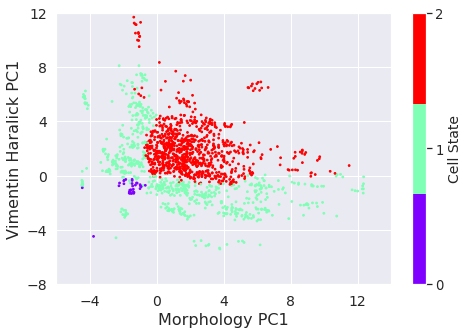

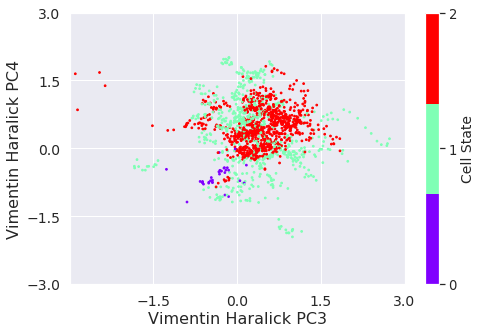

In [107]:
X=M_data
ls2_labels=ls2.predict(X)
ls2_proba=ls2.predict_proba(X)
plt.figure(figsize=(7.5,5))

plt.scatter(X[:, 0], X[:, 1], c=ls2_labels, zorder=10, cmap=cmap,norm=norm,s=3)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=14)
plt.axis('tight')
plt.axis([-6,14,-8,12])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'Mlabel_pc1.png',dpi=300)

plt.show()

plt.figure(figsize=(7.5,5))

plt.scatter(X[:, 2], X[:, 3], c=ls2_labels, zorder=10, cmap=cmap,norm=norm,s=3)
plt.xlabel('Vimentin Haralick PC3',fontsize=16)
plt.ylabel('Vimentin Haralick PC4',fontsize=16)

cbar=plt.colorbar(ticks=[0,1,2])
cbar.ax.set_ylabel('Cell State',fontsize=14)
plt.axis('equal')
plt.axis('tight')
plt.axis([-3,3,-3,3])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'Mlabel_pc34.png',dpi=300)

plt.show()

(686, 4)


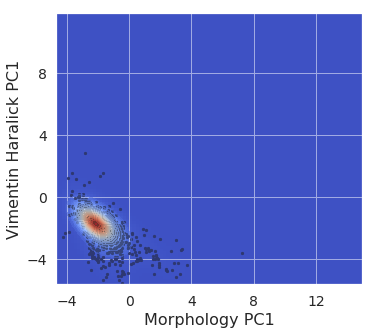

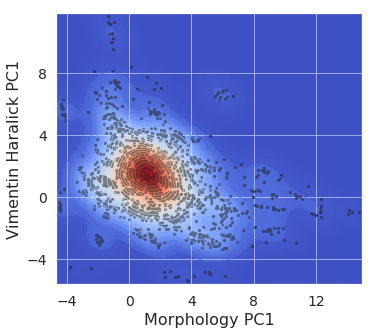

In [108]:
from sklearn.neighbors import KernelDensity
import scipy.stats as st

x_min = X[:, 0].min()-0.2
x_max = X[:, 0].max()+0.2
y_min = X[:, 1].min()-0.2
y_max = X[:, 1].max()+0.2


XX, YY = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

# kd1=KernelDensity(bandwidth=0.1,kernel='gaussian')
# kd1.fit(X[ls2_labels==0][:,:2])
# Z1 = kd1.score_samples(np.c_[XX.ravel(), YY.ravel()])
# Z1 = Z1.reshape(XX.shape)
# kd2=KernelDensity(bandwidth=2,kernel='gaussian')
# kd2.fit(X[ls2_labels==2][:,:2])
# Z2 = kd2.score_samples(np.c_[XX.ravel(), YY.ravel()])
# Z2 = Z2.reshape(XX.shape)

# kd = st.gaussian_kde(np.vstack([X[ls2_labels==2][:,2], X[ls2_labels==2][:,3]]))
# kd = st.gaussian_kde(np.vstack([X[:,0], X[:,1]]))
kd = st.gaussian_kde(np.vstack([P_data[:,0], P_data[:,1]]))
Z = np.reshape(kd(np.vstack([XX.ravel(), YY.ravel()])).T, XX.shape)

print(X[ls2_labels==1].shape)
kd1 = st.gaussian_kde(np.vstack([E_data[:,0], E_data[:,1]]),bw_method=0.7)
Z1 = np.reshape(kd1(np.vstack([XX.ravel(), YY.ravel()])).T, XX.shape)
kd2 = st.gaussian_kde(np.vstack([M_data[:,0], M_data[:,1]]))
Z2 = np.reshape(kd2(np.vstack([XX.ravel(), YY.ravel()])).T, XX.shape)



fig = plt.figure(figsize=(7.5,5))
ax = fig.gca()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.scatter(E_data[:,0],E_data[:,1],s=5,color='k')


cfset = ax.contourf(XX, YY, Z1, 20,alpha=0.5,cmap='coolwarm')
ax.imshow(np.rot90(Z1), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
# cset = ax.contour(XX, YY,Z1, colors='k')
# ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Morphology PC1',fontsize=16)
ax.set_ylabel('Vimentin Haralick PC1',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'kde_E.png',dpi=300)

plt.show()

fig = plt.figure(figsize=(7.5,5))
ax = fig.gca()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.scatter(M_data[:,0],M_data[:,1],s=5,color='k')

cfset = ax.contourf(XX, YY, Z2, 20,alpha=0.5,cmap='coolwarm')
ax.imshow(np.rot90(Z2), cmap='coolwarm', extent=[x_min, x_max, y_min, y_max])
# cset = ax.contour(XX, YY,Z1, colors='k')
# ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Morphology PC1',fontsize=16)
ax.set_ylabel('Vimentin Haralick PC1',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'kde_M.png',dpi=300)

plt.show()



# fig = plt.figure(figsize=(13, 7))
# ax = fig.gca(projection='3d')

# mask1=np.where((XX>2)|(XX<-7)|(YY>2)|(YY<-7))
# mask2=np.where((XX>8)|(XX<-4)|(YY>8)|(YY<-4))

# Z1[mask1] = np.nan
# Z1[Z2>0.02]=np.nan
# Z2[mask2] = np.nan
# Z=Z1.copy()
# Z[Z2>Z1]=Z2[Z2>Z1]

# surf=ax.plot_surface(XX, YY, -Z, rstride=2, cstride=2, cmap='winter')

# surf1=ax.plot_surface(XX, YY, -Z1,alpha=0.4,rstride=2, cstride=2, cmap='winter', edgecolor='none')
 
# surf2=ax.plot_surface(XX, YY, -Z2, alpha=0.5,rstride=2,cstride=2,cmap='autumn',  edgecolor='none')
# ax.plot_wireframe(XX, YY, -Z,alpha=0.3,color='g')


# surf1=ax.plot_wireframe(XX, YY, -Z1-0.01,alpha=0.3,color='b')
# surf2=ax.plot_wireframe(XX, YY, -Z2,alpha=0.5,color='r')
# ax.contourf(XX, YY, Z, offset=np.amin(-Z-0.01),cmap='coolwarm')


# ax.set_xlabel('Morphology PC1',fontsize=16)
# ax.set_ylabel('Vimentin Haralick PC1',fontsize=16)
# ax.set_zlabel('PDF')
# ax.set_title('Surface plot of Gaussian 2D KDE')
# fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF

# ax.view_init(30, -30)
# plt.show()

In [20]:
sct_list=['/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/single_cell_traj/fluor_sct_xy4_7_long_traj']


for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp)
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
            print(sct_list[i])
        
            mask=sct.traj_vimentin_feature_values[0]!=0
               
            traj_t=sct.traj_seri[mask][:,0]
            morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
            print(sct.traj_vimentin_scale_haralick_pca_cord[mask].shape)
            vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            
            
            
#             X0=np.column_stack((sct.traj_scale_cord[mask][:,:],sct.traj_vimentin_scale_haralick_pca_cord[mask][:,:]))

            X=np.column_stack((morph_traj[:,0],vim_traj[:,[0,2,3]]))
            X[:,2]=-X[:,2]
            dot_color=np.arange(X.shape[0])/6
            cm=plt.cm.get_cmap('jet')
            plt.figure(figsize=(7.5,5))
            plt.scatter(X[:,0],X[:,1],c=dot_color,cmap=cm)
            plt.xlabel('Morphology PC1',fontsize=16)
            plt.ylabel('Vimentin Haralick PC1',fontsize=16)
            plt.colorbar()
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.savefig(result_path+'fluor_sct_xy4_7_pc1.png',dpi=300)
            plt.show()
            plt.figure(figsize=(7.5,5))
            plt.scatter(X[:,2],X[:,3],c=dot_color,cmap=cm)
            plt.xlabel('Vimentin Haralick PC3',fontsize=16)
            plt.ylabel('Vimentin Haralick PC4',fontsize=16)
            plt.colorbar()
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.savefig(result_path+'fluor_sct_xy4_7_pc34.png',dpi=300)
            plt.show()
            
            
            cmap = plt.cm.rainbow  # define the colormap
            cmaplist = [cmap(i) for i in range(cmap.N)]
            # # force the first color entry to be grey
            # cmaplist[0] = (.5, .5, .5, 1.0)

            # create the new map
            cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

            # define the bins and normalize
            bounds = np.linspace(0, 2, 4)
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

            traj_state=ls2.predict(X)
            plt.figure(figsize=(7.5,5))
            plt.scatter(X[:,0],X[:,1],c=traj_state, edgecolor='k',cmap=cmap,norm=norm)
            plt.xlabel('Morphology PC1',fontsize=16)
            plt.ylabel('Vimentin Haralick PC1',fontsize=16)
            plt.axis('tight')
            cbar=plt.colorbar(ticks=[0,1,2])
            cbar.ax.set_ylabel('Cell State',fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.savefig(result_path+'fluor_sct_xy4_7_state_pc1.png',dpi=300)

            plt.show()
            
            plt.figure(figsize=(7.5,5))
            plt.scatter(X[:,2],X[:,3],c=traj_state, edgecolor='k',cmap=cmap,norm=norm)
            plt.xlabel('Vimentin Haralick PC3',fontsize=16)
            plt.ylabel('Vimentin Haralick PC4',fontsize=16)
            plt.axis('tight')
            cbar=plt.colorbar(ticks=[0,1,2])
            cbar.ax.set_ylabel('Cell State',fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.savefig(result_path+'fluor_sct_xy4_7_state_pc34.png',dpi=300)

            plt.show()
            
            
            fig= plt.figure(figsize=(12,8))
            ax = fig.add_subplot(111,projection='3d')
            ax.view_init(azim=235, elev=50)
            s3d=ax.scatter3D(X[:,0],X[:,1],X[:,2],c=traj_state,edgecolor='k',cmap=cmap,norm=norm,s=40)
            
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)

            for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.set_xlabel('Morphology PC1',fontsize=16,labelpad=15)
            ax.set_ylabel('Vimentin Haralick PC1',fontsize=16,labelpad=15)
            ax.set_zlabel('Vimentin Haralick PC3',fontsize=16,labelpad=15)
            cbar=fig.colorbar(s3d,shrink=0.5,aspect=20,ticks=[0,1,2])
            cbar.ax.set_ylabel('Cell State',fontsize=14)

            plt.savefig(result_path+'traj_state_label.png',dpi=300)


            plt.show()

In [395]:
# # gmm=mixture.BayesianGaussianMixture(n_components=7,covariance_type='full', weight_concentration_prior_type='dirichlet_process').fit(EM_data)

# X=EM_data
# yl=np.concatenate((np.zeros((E_data.shape[0],)),np.ones((M_data.shape[0]))))



# gmm=mixture.GaussianMixture(n_components=2,covariance_type='diag').fit(EM_data)
# gmm_proba=gmm.predict_proba(EM_data)
# plt.hist(gmm_proba)
# plt.show()
# gmm_labels=gmm.predict(EM_data)

# # gmm_labels[(yl==0)&(ori_gmm_labels==0)]=0
# # gmm_labels[(yl==1)&(ori_gmm_labels==1)]=2
# # gmm_labels[yl!=ori_gmm_labels]=1

# plt.scatter(EM_data[:,0],EM_data[:,1],c=gmm_labels,s=1)
# # plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.axis('equal')

# # plt.savefig(result_path+'gmm.png',dpi=300)
# plt.show()

# plt.scatter(EM_data[:,2],EM_data[:,3],c=gmm_labels,s=1)
# # plt.scatter(gmm.means_[:,0],gmm.means_[:,1])
# plt.xlabel('Vimentin haralick PC3',fontsize=16)
# plt.ylabel('Vimentin haralick PC4',fontsize=16)
# plt.axis('equal')
# plt.show()


# ax = plt.axes(projection='3d')
# ax.scatter3D(EM_data[:,1],EM_data[:,2],EM_data[:,0],c=gmm_labels,s=0.1)
# plt.show()

# # with open (main_path+'scale_gmm', 'wb') as fp:
# #     pickle.dump(gmm,fp)



# mask_i=(X[:,0]<-1)&(X[:,1]<-1)&(X[:,2]>0)&(X[:,3]<0)
# mask_f=(X[:,0]>-0.4)&(X[:,1]>-0.4)&(X[:,2]<0)&(X[:,3]>0)

# yl[mask_i]=0
# yl[mask_f]=2
# yl[~(mask_i|mask_f)]=1
# X=EM_data
# ls2=LabelSpreading(kernel='knn',n_neighbors=60,alpha=0.9)
# print(X.shape)
# ls2.fit(X,yl)


# ls2_labels=ls2.predict(X)
# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=ls2_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)

# plt.axis('tight')
# plt.show()



# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=yl, zorder=10,cmap=plt.cm.Paired, s=0.5)

# plt.axis('tight')
# plt.show()
#

In [394]:
#  kernel = 1.0 * RBF([1.0, 1.0,1.0,1.0])
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(EM_data, yl)

# gpc_proba=gpc.predict_proba(EM_data)
# gpc_labels=gpc.predict(EM_data)

# # mask=gpc_proba[:,1]>0.99
# # gpc_labels[mask]=1
# # gpc_labels[~mask]=0
# # gpc_labels[(gpc_proba[:,0]-gpc_proba[:,1])<-0.55]=2
# # gpc_labels[(gpc_proba[:,0]-gpc_proba[:,1])>0.9]=0
# # gpc_labels[((gpc_proba[:,0]-gpc_proba[:,1])>=-0.5)&((gpc_proba[:,0]-gpc_proba[:,1])<0.9)]=1

# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=gpc_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)

# plt.axis('tight')
# plt.show()


# plt.hist(gpc_proba[:,0]-gpc_proba[:,1],bins=20)
# plt.show()


# knnc=RadiusNeighborsClassifier(radius=5,p=1,weights='distance').fit(EM_data,gmm_labels)
# # knnc_proba=knnc.predict_proba(EM_data)
# knnc_labels=knnc.predict(EM_data)

# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=knnc_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)

# plt.axis('tight')
# plt.show()


# plt.hist(knnc_proba,bins=20)
# plt.show()

In [173]:
# from sklearn.neighbors import KernelDensity
# X=EM_data
# kde_score_range=np.zeros((2,2))
# kd1=KernelDensity(bandwidth=2,kernel='gaussian')
# kd1.fit(E_data)
# x_min = X[:, 0].min()
# x_max = X[:, 0].max()
# y_min = X[:, 1].min()
# y_max = X[:, 1].max()


# XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
# Z1 = kd1.score_samples(np.c_[XX.ravel(), YY.ravel()])

# kde_score_range[0,0],kde_score_range[0,1]=np.amin(Z1),np.amax(Z1)

# Z1=(Z1-np.amin(Z1))/(np.amax(Z1)-np.amin(Z1))
# print(Z1.shape)
# plt.hist(Z1)
# plt.show()
# # Z1[Z1<0.75]=0.75
# # Put the result into a color plot
# Z1 = Z1.reshape(XX.shape)
# # plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
# plt.scatter(E_data[:, 0], E_data[:, 1], c='b', zorder=10,cmap=plt.cm.Paired, s=0.5)

# plt.contour(XX, YY, Z1, 200)
# plt.contourf(XX, YY, Z1,200,cmap=plt.cm.get_cmap('jet'))
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.axis('tight')
# plt.colorbar()
# # plt.savefig(result_path+'kde_E.tif',dpi=300)
# plt.show()


# kd2=KernelDensity(bandwidth=3,kernel='gaussian')
# kd2.fit(M_data)
# Z2 = kd2.score_samples(np.c_[XX.ravel(), YY.ravel()])
# kde_score_range[1,0],kde_score_range[1,1]=np.amin(Z2),np.amax(Z2)

# Z2=(Z2-np.amin(Z2))/(np.amax(Z2)-np.amin(Z2))
# plt.hist(Z2)
# plt.show()
# # Z2[Z2<0.75]=0
# # Put the result into a color plot
# Z2 = Z2.reshape(XX.shape)
# # plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
# plt.scatter(M_data[:, 0], M_data[:, 1], c='b', zorder=10,cmap=plt.cm.Paired, s=0.5)
# plt.contour(XX, YY, Z2, 200)
# plt.contourf(XX, YY, Z2,200,cmap=plt.cm.get_cmap('jet'))
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.axis('tight')
# plt.colorbar()
# # plt.savefig(result_path+'kde_M.tif',dpi=300)
# plt.show()


# plt.scatter(E_data[:, 0], E_data[:, 1], c='b',zorder=10,cmap=plt.cm.Paired, s=0.5)
# plt.scatter(M_data[:, 0], M_data[:, 1], c='r',zorder=10,cmap=plt.cm.Paired, s=0.5)
# plt.contour(XX, YY, Z1-Z2, 30)
# plt.contourf(XX, YY, Z1-Z2,30,cmap=plt.cm.get_cmap('jet'))

# # plt.axis([-6,8,-6,8])
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.colorbar()
# # plt.savefig(result_path+'kde_E-M.tif',dpi=300)
# plt.show()

# # with open (main_path+'kde_E', 'wb') as fp:
# #     pickle.dump(kd1,fp)
# # with open (main_path+'kde_M', 'wb') as fp:
# #     pickle.dump(kd2,fp)

# print(kde_score_range)
# # np.save(main_path+'kde_score_range.npy',kde_score_range)

In [393]:
# all_t=np.concatenate(all_t0,axis=0)




# mask1=all_t<24
# E_data=np.column_stack((Y1[mask1][:,0],Y2[mask1][:,[0,2,3]]))
# print(np.std(E_data,axis=0))

# mask2=(all_t>271)&(all_t<307)
# P_data=np.column_stack((Y1[mask2][:,0],Y2[mask2][:,[0,2,3]]))
# print(np.std(P_data,axis=0))
# mask3=all_t>552
# # mask4=Y1[:,0]>-3
# M_data=np.column_stack((Y1[mask3][:,0],Y2[mask3][:,[0,2,3]]))
# print(np.std(M_data,axis=0))
# print(E_data.shape[0]*1.0/M_data.shape[0])

# EM_data=np.vstack((E_data,M_data))
# EPM_data=np.vstack((EM_data,P_data))
# X=EM_data
# yl=np.concatenate((np.zeros((E_data.shape[0],)),np.ones((M_data.shape[0]))))
# yl[(X[:,0]<-1)&(X[:,1]<-1)]=0
# yl[(X[:,0]>0.1)&(X[:,1]>-0.1)]=2
# yl[(X[:,0]>-1)&(X[:,1]<0)]=1
# yl[(X[:,0]<-1)&(X[:,1]>0)]=2

# kde_score_range=np.zeros((2,2))
# kd1=KernelDensity(bandwidth=2,kernel='gaussian')
# kd1.fit(E_data)
# x1_min = X[:, 0].min()
# x1_max = X[:, 0].max()
# x2_min = X[:, 1].min()
# x2_max = X[:, 1].max()
# x3_min = X[:, 2].min()
# x3_max = X[:, 2].max()
# x4_min = X[:, 3].min()
# x4_max = X[:, 3].max()
# xx1 = np.linspace(x1_min, x1_max, 10)
# xx2 = np.linspace(x2_min, x2_max, 10)
# xx3 = np.linspace(x3_min, x3_max, 10)
# xx4 = np.linspace(x4_min, x4_max, 10)

# XX1,XX2,XX3,XX4 = np.meshgrid(xx1,xx2,xx3,xx4)
# Z1 = kd1.score_samples(np.c_[XX1.ravel(), XX2.ravel(),XX3.ravel(),XX4.ravel()])
# print(XX1.shape,Z1.shape)
# kde_score_range[0,0],kde_score_range[0,1]=np.amin(Z1),np.amax(Z1)

# Z1=(Z1-np.amin(Z1))/(np.amax(Z1)-np.amin(Z1))
# print(Z1.shape)
# plt.hist(Z1)
# plt.show()
# # Z1[Z1<0.75]=0.75
# # Put the result into a color plot
# Z1 = Z1.reshape((100,10,10))
# # plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
# plt.scatter(E_data[:, 2], E_data[:, 3], c='b', zorder=10,cmap=plt.cm.Paired, s=0.5)

# z2d=np.sum(Z1,axis=0)
# plt.contour(XX3[0,0,:,:], XX4[0,0,:,:], z2d,20)
# plt.contourf(XX3[0,0,:,:], XX4[0,0,:,:],z2d,20,cmap=plt.cm.get_cmap('jet'))
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.axis('tight')
# plt.colorbar()
# # plt.savefig(result_path+'kde_E.tif',dpi=300)
# plt.show()

In [311]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=2, kernel='epanechnikov'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0]*1.0 / X.shape[0])
                           for Xi in training_sets]
        print(self.logpriors_)

        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T

        result = np.exp(logprobs + self.logpriors_)

        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [396]:
# kd0=KDEClassifier().fit(X,yl)


# kd_proba=kd0.predict_proba(X)
# plt.hist(kd_proba)
# plt.show()

# kd_labels=kd0.predict(X)

# # kd_labels[kd_proba>0.7]=2
# # kd_labels[kd_proba<-0.7]=0
# # kd_labels[(kd_proba>-0.7)&(kd_proba<0.7)]=1
# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=kd_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)
# plt.show()


# ls2=LabelSpreading(kernel='knn',n_neighbors=10,alpha=0.9)

# ls2.fit(X,kd_labels)

# plt.figure()

# x_min = X[:, 0].min()
# x_max = X[:, 0].max()
# y_min = X[:, 1].min()
# y_max = X[:, 1].max()


# XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
# Z = ls2.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,1]
# Z = Z.reshape(XX.shape)

# # print(Z.shape)
# ls2_labels=ls2.predict_proba(X)
# plt.hist(ls2_labels)
# plt.show()
# ls2_labels=ls2.predict(X)
# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=ls2_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)
# # plt.contourf(XX, YY, Z,  20,cmap=plt.cm.get_cmap('Greys'))
# # plt.contour(XX, YY, Z, 20)

# plt.colorbar()
# # plt.savefig(result_path+'label_spreading_P.tif',dpi=300)
# plt.axis('tight')
# plt.show()

In [34]:
# from sklearn import datasets, svm
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.semi_supervised import LabelSpreading

# print(X.shape,gmm_labels.shape)

# # clf = svm.SVC(kernel='rbf',gamma=20, probability=True)
# # clf=KNeighborsClassifier(n_neighbors=5,leaf_size=100)


# ls=LabelSpreading(kernel='knn',n_neighbors=40,alpha=0.99)

# ls.fit(X, gmm_labels)

# plt.figure()

# # plt.axis('tight')
# x_min = X[:, 0].min()
# x_max = X[:, 0].max()
# y_min = X[:, 1].min()
# y_max = X[:, 1].max()

# XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
# Z = clf.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,0]
# print(Z.shape)
# plt.hist(Z)
# plt.show()
# # Put the result into a color plot
# Z = Z.reshape(XX.shape)

# ls_prob=ls.predict_proba(X)
# ls_labels=ls.predict(X)
# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=ls_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)

# plt.contourf(XX, YY, Z,  50,cmap=plt.cm.get_cmap('jet'))
# plt.contour(XX, YY, Z, 50)
# plt.colorbar()
# plt.axis('tight')
# plt.show()

In [392]:

# X=EM_data

# kd1_score=(kd1.score_samples(X)-kde_score_range[0,0])/(kde_score_range[0,1]-kde_score_range[0,0])
# kd2_score=(kd2.score_samples(X)-kde_score_range[1,0])/(kde_score_range[1,1]-kde_score_range[1,0])

# # kd1_score=(kd1.score_samples(X)-np.amin(kd1.score_samples(X)))/(np.amax(kd1.score_samples(X))-np.amin(kd1.score_samples(X)))
# # kd2_score=(kd2.score_samples(X)-np.amin(kd2.score_samples(X)))/(np.amax(kd2.score_samples(X))-np.amin(kd2.score_samples(X)))

# plt.hist(kd1_score)
# plt.show()

# kde_labels=-1*np.ones(X.shape[0])
# kde_labels[(kd1_score-kd2_score)>0.08]=0
# kde_labels[(kd1_score-kd2_score)<-0.04]=2
# # kde_labels[kd1_score>0.96]=0
# # kde_labels[kd2_score>0.95]=2
# mask=(kde_labels!=-1)
# kde_labels[~mask]=1

# plt.hist(kde_labels)
# plt.show()
# # clf2=LabelPropagation(kernel='knn',n_neighbors=10)
# ls2=LabelSpreading(kernel='knn',n_neighbors=10,alpha=0.9)
# print(X[mask].shape)
# ls2.fit(X,kde_labels)

# plt.figure()

# Z = ls2.predict_proba(np.c_[XX.ravel(), YY.ravel()])[:,1]
# Z = Z.reshape(XX.shape)

# print(Z.shape)
# ls2_labels=ls2.predict_proba(X)
# plt.hist(ls2_labels)
# plt.show()
# ls2_labels=ls2.predict(X)
# plt.scatter(EM_data[:, 0], EM_data[:, 1], c=ls2_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)
# plt.contourf(XX, YY, Z,  20,cmap=plt.cm.get_cmap('jet'))
# # plt.contour(XX, YY, Z, 20)

# plt.colorbar()
# # plt.savefig(result_path+'label_spreading_P.tif',dpi=300)
# plt.axis('tight')
# plt.show()

# # plt.scatter(EM_data[:, 0], EM_data[:, 1], c=ls2_labels, zorder=10,cmap=plt.cm.Paired, s=0.5)
# # plt.show()

# # with open (main_path+'label_spread', 'wb') as fp:
# #     pickle.dump(ls2,fp)

In [77]:
#--------test clustering method
# from sklearn.cluster import DBSCAN

# clustering = DBSCAN(eps=1.2, min_samples=30).fit(M_data)
# plt.scatter(M_data[:,0],M_data[:,1],c=clustering.labels_,s=1)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.show()

# from sklearn.cluster import Birch

# brc = Birch(branching_factor=20, n_clusters=2, threshold=2,compute_labels=True)
# brc.fit(EM_data) 
# plt.scatter(EM_data[:,0],EM_data[:,1],c=brc.labels_,s=1)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.show()


# from sklearn.cluster import AffinityPropagation

# clustering = AffinityPropagation().fit(EM_data)
# plt.scatter(EM_data[:,0],EM_data[:,1],c=clustering.labels_,s=1)
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin haralick PC1',fontsize=16)
# plt.show()

# X, Y = np.meshgrid(np.linspace(-6, 8,500), np.linspace(-8,8,500))
# XX = np.array([X.ravel(), Y.ravel()]).T
# Z = gmm.score_samples(XX)
# Z = Z.reshape((500,500))
 
# plt.contour(X, Y, Z)
# # plt.scatter(X_train[:, 0], X_train[:, 1])
 
# plt.show()

In [87]:
all_t=np.concatenate(all_t0,axis=0)

mask1=all_t<=24
E_morph=sY1[mask1]
E_vim=sY2[mask1][:,:4]


mask2=(all_t>271)&(all_t<307)
P_morph=sY1[mask2]
P_vim=sY2[mask2]

mask3=all_t>552
M_morph=sY1[mask3]
M_vim=sY2[mask3]

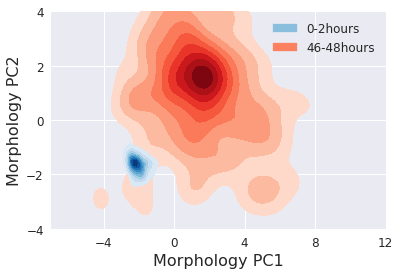

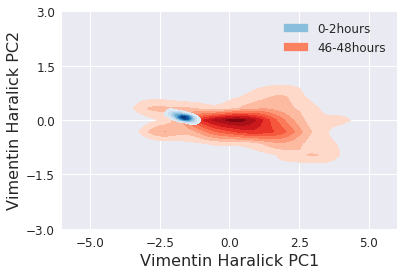

In [88]:
# E_morph_df=pd.DataFrame(E_morph, columns=['Morphology_PC1','Morphology_PC2'])
# g = sns.jointplot('Morphology_PC1','Morphology_PC2',data=E_morph_df,kind="kde", xlim=(-5,10),ylim=(-4,4), space=0, color="g")
# plt.title('0-2hours',fontsize=16)
# plt.show()

# M_morph_df=pd.DataFrame(M_morph, columns=['Morphology_PC1','Morphology_PC2'])
# g = sns.jointplot('Morphology_PC1','Morphology_PC2',data=M_morph_df,kind="kde",xlim=(-5,10),ylim=(-4,4),  space=0, color="g")
# plt.title('46-48hours',fontsize=16)
# plt.show()


label_patch2=mpatches.Patch(color=sns.color_palette('Reds')[2],label='46-48hours')
label_patch1=mpatches.Patch(color=sns.color_palette('Blues')[2],label='0-2hours')
label_patches=[label_patch1,label_patch2]

ax = sns.kdeplot(M_morph[:,0],M_vim[:,0],cmap="Reds",n_levels=10, shade=True, shade_lowest=False)
ax = sns.kdeplot(E_morph[:,0],E_vim[:,0],cmap="Blues", n_levels=10, shade=True, shade_lowest=False)
plt.legend(handles=label_patches, loc='upper right')
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Morphology PC2',fontsize=16)
plt.axis([-7,12,-4,4],'equal')
# plt.savefig(result_path+'morph_start_end_kde.tif',dpi=300)
plt.show()

ax = sns.kdeplot(M_vim[:,0],M_vim[:,1],cmap="Reds",n_levels=10, shade=True, shade_lowest=False)
ax = sns.kdeplot(E_vim[:,0],E_vim[:,1],cmap="Blues", n_levels=10, shade=True, shade_lowest=False)
plt.legend(handles=label_patches, loc='upper right')
plt.xlabel('Vimentin Haralick PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC2',fontsize=16)
plt.axis([-6,6,-3,3],'equal')
# plt.savefig(result_path+'vim_start_end_kde.tif',dpi=300)
plt.show()

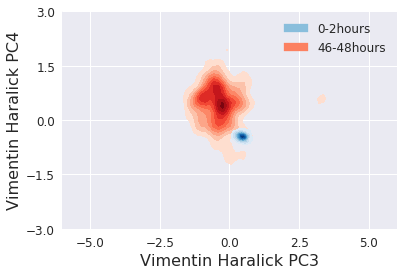

In [90]:
ax = sns.kdeplot(M_vim[:,2],M_vim[:,3],cmap="Reds",n_levels=10, shade=True, shade_lowest=False)
ax = sns.kdeplot(E_vim[:,2],E_vim[:,3],cmap="Blues", n_levels=10, shade=True, shade_lowest=False)
plt.legend(handles=label_patches, loc='upper right')
plt.xlabel('Vimentin Haralick PC3',fontsize=16)
plt.ylabel('Vimentin Haralick PC4',fontsize=16)
plt.axis([-6,6,-3,3],'equal')
plt.show()

In [91]:
s_Y=np.column_stack((sY1[:,0],sY2[:,[0,2,3]]))

mask0=(all_t<=24)
h0=s_Y[mask0]
h0_proba=ls2.predict_proba(h0)[:,2]

h0_labels=ls2.predict(h0)
# h0_proba_df=pd.DataFrame(h0_proba, columns=['Epithelial_state','Mesenchymal_state'])
# g = sns.jointplot('Epithelial_state','Mesenchymal_state',data=h0_proba_df,kind="kde",space=0, color="g")

# plt.title('0-2hour')
# plt.show()

mask12=(all_t>133)&(all_t<157)
h12=s_Y[mask12]
h12_proba=ls2.predict_proba(h12)[:,2]
h12_labels=ls2.predict(h12)


mask24=(all_t>277)&(all_t<301)
h24=s_Y[mask24]
h24_proba=ls2.predict_proba(h24)[:,2]
h24_labels=ls2.predict(h24)

mask30=(all_t>348)&(all_t<372)
h30=s_Y[mask30]
h30_proba=ls2.predict_proba(h30)[:,2]
h24_labels=ls2.predict(h24)

mask36=(all_t>421)&(all_t<445)
h36=s_Y[mask36]
h36_proba=ls2.predict_proba(h36)[:,2]
h36_labels=ls2.predict(h36)



mask42=(all_t>492)&(all_t<516)
h42=s_Y[mask42]
h42_proba=ls2.predict_proba(h42)[:,2]
h42_labels=ls2.predict(h42)


mask44=(all_t>516)&(all_t<540)
h44=s_Y[mask44]
h44_proba=ls2.predict_proba(h44)[:,2]
h44_labels=ls2.predict(h44)

mask5=all_t>552
h48=s_Y[mask5]
h48_proba=ls2.predict_proba(h48)[:,2]
h48_labels=ls2.predict(h48)




# plt.figure(figsize=(10,6))

# # cmaps = ['Reds', 'Blues', 'Greens', 'Greys']
# # sns.kdeplot(h0_proba,label='0-2 hour')
# # sns.kdeplot(h12_proba,label='11-13 hour')
# sns.kdeplot(h24_proba,label='23-25 hour')
# sns.kdeplot(h30_proba,label='29-31 hour')
# sns.kdeplot(h36_proba,label='35-37 hour')
# sns.kdeplot(h42_proba,label='41-43 hour')
# sns.kdeplot(h44_proba,label='43-45 hour')

# sns.kdeplot(h48_proba,label='46-48 hour')

# plt.xlabel('Predicted Probability of Mesenchymal State \n by Label Propagation Function',fontsize=16)
# plt.ylabel('Probability Density by KDE',fontsize=16)
# plt.legend()
# # plt.savefig(result_path+'ls_proba_M_state.tif',dpi=300)
# plt.show()

/home/zoro/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/zoro/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/zoro/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/zoro/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/zoro/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarnin

{'E_state': [1474, 471, 111, 90, 74, 49], 'M_state': [0, 82, 789, 984, 1013, 954], 'I_state': [423, 1621, 1210, 743, 642, 630]}
[0.7770163415919874, 0.21665133394664213, 0.05260663507109005, 0.04953219592735278, 0.042799305957200696, 0.030006123698714023]


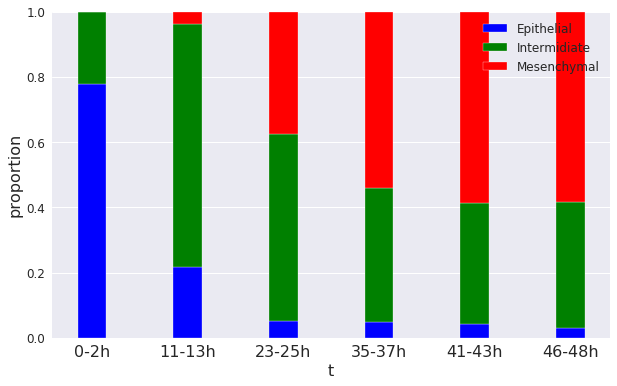

In [92]:
r = [0,1,2,3,4,5]
raw_data = {'E_state': [h0_labels[h0_labels==0].shape[0], h12_labels[h12_labels==0].shape[0],h24_labels[h24_labels==0].shape[0],\
                        h36_labels[h36_labels==0].shape[0], h42_labels[h42_labels==0].shape[0],h48_labels[h48_labels==0].shape[0]], \
            'I_state': [h0_labels[h0_labels==1].shape[0], h12_labels[h12_labels==1].shape[0],h24_labels[h24_labels==1].shape[0],\
                        h36_labels[h36_labels==1].shape[0],h42_labels[h42_labels==1].shape[0],h48_labels[h48_labels==1].shape[0]],\
            'M_state': [h0_labels[h0_labels==2].shape[0],h12_labels[h12_labels==2].shape[0],h24_labels[h24_labels==2].shape[0],\
                        h36_labels[h36_labels==2].shape[0],h42_labels[h42_labels==2].shape[0],h48_labels[h48_labels==2].shape[0]]}
df = pd.DataFrame(raw_data)
print(raw_data)
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['E_state'], df['I_state'], df['M_state'])]
E_state = [i *1.0/ j  for i,j in zip(df['E_state'], totals)]
I_state = [i*1.0 / j  for i,j in zip(df['I_state'], totals)]
M_state = [i *1.0/ j  for i,j in zip(df['M_state'], totals)]
print(E_state)
# plot

plt.figure(figsize=(10,6))
barWidth = 0.3
names = ('0-2h','11-13h','23-25h','35-37h','41-43h','46-48h')
# Create green Bars
plt.bar(r, E_state, color='b', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, I_state, bottom=E_state, color='g', edgecolor='white', width=barWidth)
# Create blue Bars
plt.bar(r, M_state, bottom=[i+j for i,j in zip(E_state, I_state)], color='r', edgecolor='white', width=barWidth)
 
# Custom x axis
plt.xticks(r, names,fontsize=16)
plt.xlabel('t',fontsize=16)
plt.ylabel('proportion',fontsize=16)
# Show graphic
plt.legend(['Epithelial','Intermidiate','Mesenchymal'],fontsize=12)
plt.show()

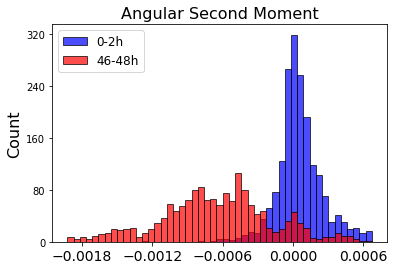

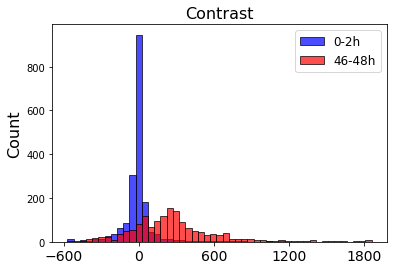

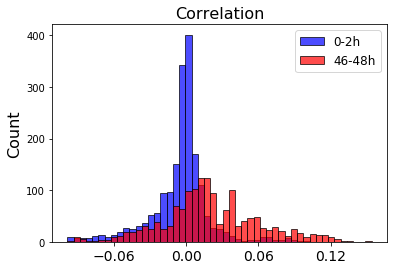

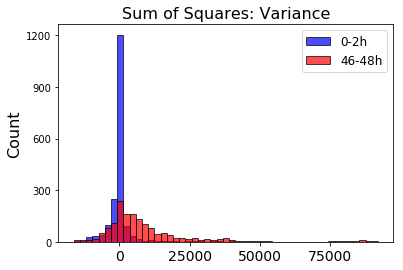

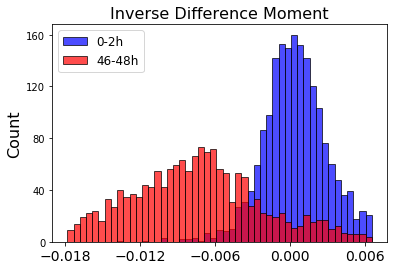

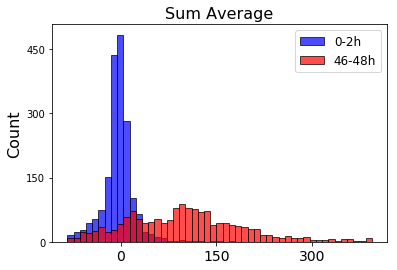

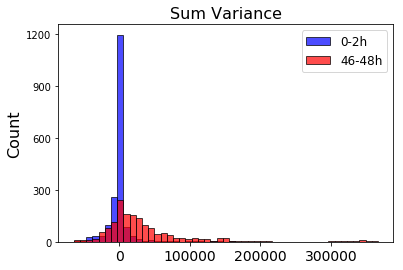

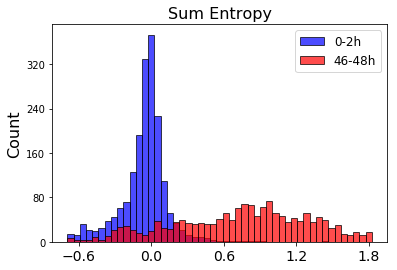

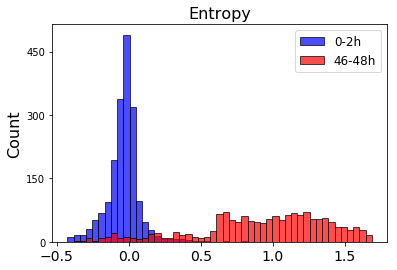

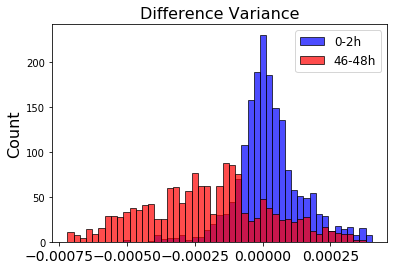

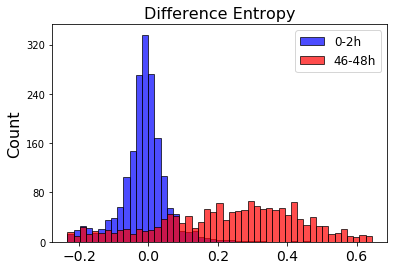

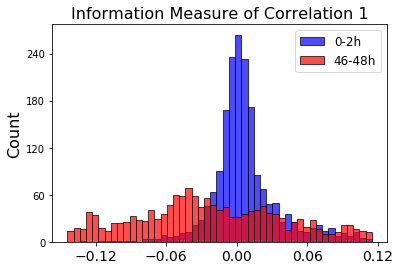

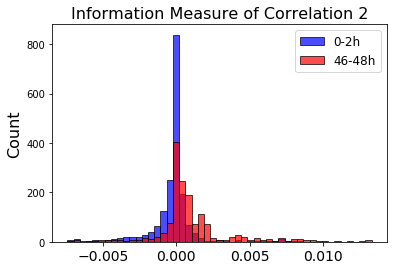

In [9]:
haralick_labels = ["Angular Second Moment",
               "Contrast",
               "Correlation",
               "Sum of Squares: Variance",
               "Inverse Difference Moment",
               "Sum Average",
               "Sum Variance",
               "Sum Entropy",
               "Entropy",
               "Difference Variance",
               "Difference Entropy",
               "Information Measure of Correlation 1",
               "Information Measure of Correlation 2"]

all_t=np.concatenate(all_t0,axis=0)
all_haralick=np.vstack(all_haralick0)
mask1=all_t<=24
E_hara=all_haralick[mask1]

# mask2=(all_t>271)&(all_t<307)
# P_hara=all_haralick[mask2]
# print(np.std(P_data,axis=0))

mask3=all_t>552
M_hara=all_haralick[mask3]

for j in range(all_haralick.shape[1]):
    bins=np.linspace(np.quantile(np.vstack((E_hara,M_hara))[:,j],0.02),np.quantile(np.vstack((E_hara,M_hara))[:,j],0.98),50)
    
    
    plt.hist(E_hara[:,j], bins=bins,alpha=0.7, label='0-2h',edgecolor='k',color='blue')
    plt.hist(M_hara[:,j], bins=bins,alpha=0.7, label='46-48h',edgecolor='k',color='red')
    plt.legend(fontsize=12)
#     plt.title(haralick_labels[j])
    plt.title(haralick_labels[j],fontsize=16)
    plt.ylabel('Count',fontsize=16)
    plt.xticks(fontsize=14)
    plt.xticks(fontsize=14)

#     plt.savefig(result_path+'/Haralick distribution/'+haralick_labels[j]+'.tif', dpi=300)
    plt.savefig(result_path+'/Haralick distribution/'+haralick_labels[j]+'.png',dpi=300)

    plt.show()

In [3]:
# #----------------mean trajectory calculation--------------------------------

# mean_traj_contour=np.zeros((577,300))
# mean_count=np.zeros((577,))
# mean_vim=np.zeros((577))
# mean_haralick=np.zeros((577,13))
# for i in range(len(sct_list)):
#     with open (sct_list[i], 'rb') as fp:
#         sct = pickle.load(fp)
#     for j in range(len(sct.traj_contour)):
#         img_num=(sct.traj_seri[j,0]).astype(np.int)

#         mean_traj_contour[img_num-1,:]+=sct.traj_contour[j,:]

#         mean_vim[img_num-1]+=sct.traj_vimentin_feature_values[0][j]
#         mean_haralick[img_num-1,:]+=sct.traj_vimentin_feature_values[3][j,:]

#         mean_count[img_num-1]+=1

# mean_traj_contour=mean_traj_contour/mean_count[:,None]
# mean_vim=mean_vim/mean_count
# mean_haralick=mean_haralick/mean_count[:,None]

# mask=mean_vim!=0
# print(mask.shape)

# for k in range(577):
#     plt.plot(mean_traj_contour[k,::2],mean_traj_contour[k,1::2],'.')
# plt.show()   
   
# dot_color=np.arange(mean_vim[mask].shape[0])
# cm=plt.cm.get_cmap('jet')

# for j in range(mean_haralick.shape[1]):
#     print(j)
#     sc=plt.scatter(np.arange(mean_haralick[mask].shape[0]),mean_haralick[mask][:,j]/mean_vim[mask],s=5,c=dot_color,cmap=cm)
#     plt.xlabel('PC1',fontsize=16)
#     plt.ylabel('PC2',fontsize=16)
#     #     plt.axis([-450,800,-400,400])
#     plt.colorbar(sc)
#     plt.show()
    
#     plt.scatter(np.arange(mean_haralick[mask].shape[0]),mean_haralick[mask][:,j],s=5,c=dot_color,cmap=cm)
#     plt.show()

In [10]:
# scale_features=[]
# scale_contours=[]
# scale_haralick=[]
# for i in range(len(sct_list)):
#     with open (sct_list[i], 'rb') as fp:
#         sct = pickle.load(fp)
    
#     mask=sct.traj_vimentin_feature_values[0]!=0
# #     scale_contours.append(sct.traj_contour[mask]/np.sqrt(sct.traj_feature[mask][0,0]))
#     scale_contours.append(sct.traj_contour[mask])
#     scale_features.append(sct.traj_feature[mask][:,key_mask])
#     traj_norm_haralick=sct.traj_vimentin_feature_values[2][mask]
#     scale_haralick.append(traj_norm_haralick)
# #     for j in range(traj_norm_haralick.shape[1]):
# #         plt.plot((traj_norm_haralick)[:,j])
# #         plt.show()

In [11]:
# scaler1 = StandardScaler()
# X1=np.vstack(scale_features)
# print(X1.shape)
# X1=scaler1.fit_transform(X1)
# pca1 = decomposition.PCA(n_components =0.98,svd_solver= 'full')
# Y1 = pca1.fit_transform(X1)
# print(pca1.explained_variance_ratio_)


# X2=np.vstack(scale_haralick)
# scaler2 = StandardScaler()

# X2=scaler2.fit_transform(X2)
# print(X2.shape)


# pca2 = decomposition.PCA(n_components =0.98,svd_solver= 'full')
# Y2 = pca2.fit_transform(X2)
# print(pca2.components_,pca2.explained_variance_ratio_)


# X=np.column_stack((X1,X2))
# pca = decomposition.PCA(n_components =0.98,svd_solver= 'full')
# Y = pca.fit_transform(X)
# print(pca.components_,pca.explained_variance_ratio_)

In [12]:
# plt.scatter(Y1[:,0],Y2[:,0],s=0.01)
# plt.show()
# sns.kdeplot(Y1[:,0],Y2[:,0],n_levels=50,shade=True)
# # # plt.axis([-2.5,2.5,-2.5,2.5])
# plt.show()


# plt.scatter(Y[:,0],Y[:,1],s=0.01)
# plt.show()
# sns.kdeplot(Y[:,0],Y[:,1],n_levels=50,shade=True)
# # # plt.axis([-2.5,2.5,-2.5,2.5])
# plt.show()

# ax = plt.axes(projection='3d')
# ax.scatter3D(Y[:,0],Y[:,1],Y[:,2],s=0.01)
# # #     ax.view_init(50, 25)
# plt.show()

In [13]:
# for i in range(len(sct_list)):
#     with open (sct_list[i], 'rb') as fp:
#         sct = pickle.load(fp)
    
#     mask=sct.traj_vimentin_feature_values[0]!=0
# #     scale_contour=sct.traj_contour[mask]
# #     scale_cord=pca1.transform(scale_contour)

#     traj_feature=sct.traj_feature[mask][:,key_mask]
#     scale_feature=scaler1.transform(traj_feature)
    
#     traj_norm_haralick=sct.traj_vimentin_feature_values[3][mask]
#     scale_haralick=scaler2.transform(traj_norm_haralick)
#     scale_haralick_cord=pca2.transform(scale_haralick)
    
#     scale_cord=pca.transform(np.column_stack((scale_feature,scale_haralick)))

#     dot_color=np.arange(scale_cord.shape[0])
#     cm=plt.cm.get_cmap('jet')
#     plt.scatter(scale_cord[:,0],scale_cord[:,1],s=5,c=dot_color,cmap=cm)
#     plt.show()
    
#     ax = plt.axes(projection='3d')
#     ax.scatter3D(scale_cord[:,0],scale_cord[:,1],s=5,c=dot_color,cmap=cm)
#     # #     ax.view_init(50, 25)
#     plt.show()

    
# #     plt.scatter(scale_cord[:,0],scale_cord[:,1],s=5,c=dot_color,cmap=cm)
# #     plt.show()
    
# #     plt.scatter(scale_haralick_cord[:,0],scale_haralick_cord[:,1],s=5,c=dot_color,cmap=cm)
# #     plt.show()